In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 16

train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [23]:
import torchvision.models as models
pre_vgg = models.vgg19_bn(pretrained=True)
sample_data, sample_label = next(iter(train_loader))
pre_vgg

/home/eslab/anaconda3/envs/kkh38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eslab/anaconda3/envs/kkh38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [24]:
list(pre_vgg.features)[0:3]
pre_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [25]:
class VGG_gradCAM(nn.Module):
    def __init__(self, pre_vgg):
        super().__init__()
        self.gradFeatureMap = dict()
        ls = list(pre_vgg.features)
        self.feats = nn.ModuleList([
            nn.Sequential(*ls[:7]),
            nn.Sequential(*ls[7:14]),
            nn.Sequential(*ls[14:27]),
            ])

        
        
        self.linear = nn.Sequential(
            nn.Linear(256*4*4, 50, bias=True),
            nn.Linear(50, 10, bias=True)
        )

    def forward(self, x):
        for feat in self.feats:
            x = feat(x)
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out
    
    def en_gradCam(self):
        def front_hook(module, grad_input, grad_output):
            self.gradFeatureMap[module] = grad_output
        def back_hook(module, grad_input, grad_output): 
            print(self.gradFeatureMap[module].shape,grad_output[0].mean(dim=(2, 3)).unsqueeze(-1).unsqueeze(-1).shape)
            self.gradFeatureMap[module] = self.gradFeatureMap[module] * grad_output[0].mean(dim=(2, 3)).unsqueeze(-1).unsqueeze(-1)
        for l in self.feats:
            l.register_forward_hook(front_hook)
            l.register_full_backward_hook(back_hook)

    def showGradCAM(self, criterion, out, label):
        loss = criterion(out, label)
        loss.backward()
        if(self.gradFeatureMap == None):
            print("en_gradCam() function not declared.")
            return None
        
        # out = nn.ReLU(True)(torch.einsum("b c w h -> b w h", list(self.gradFeatureMap.values())[0]))
        out = nn.ReLU(True)(torch.einsum("b c w h -> b w h", torch.nn.functional.interpolate(list(self.gradFeatureMap.values())[0], size=(32, 32), mode = 'bilinear', align_corners=False)))
        for i in list(self.gradFeatureMap.values())[1:]:
            out = out + nn.ReLU(True)(torch.einsum("b c w h -> b w h", torch.nn.functional.interpolate(i, size=(32, 32), mode = 'bilinear', align_corners=False)))

        return out

In [26]:
model = VGG_gradCAM(pre_vgg)
model

VGG_gradCAM(
  (feats): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2

In [27]:
model = VGG_gradCAM(pre_vgg)
model.en_gradCam()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

out= model(torch.randn(4, 3, 32, 32))
loss = criterion(out, torch.tensor([1, 2, 3, 4]))

model.showGradCAM(criterion, out, torch.tensor([1, 2, 3, 4])).shape

torch.Size([4, 256, 4, 4]) torch.Size([4, 256, 1, 1])
torch.Size([4, 128, 8, 8]) torch.Size([4, 128, 1, 1])
torch.Size([4, 64, 16, 16]) torch.Size([4, 64, 1, 1])


torch.Size([4, 32, 32])

In [28]:
for i in list(model.gradFeatureMap.values()):
    print(i.shape)

torch.Size([4, 64, 16, 16])
torch.Size([4, 128, 8, 8])
torch.Size([4, 256, 4, 4])


In [29]:
model = VGG_gradCAM(pre_vgg)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.001

### PRETRAINED MODEL LOAD

In [30]:
model.load_state_dict(torch.load('model_0.018459813161543572_.pt'))

<All keys matched successfully>

### TRAIN

In [31]:
# from tqdm import tqdm
# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=20, gamma=0.5) 

# epochs = 100
# for ep in range(epochs):
#     progressbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
#     losses = 0
#     for i, (data, label) in enumerate(progressbar):
#         optimizer.zero_grad()
#         data = data.to(device)
#         label = label.to(device)
#         out = model(data)
#         loss = criterion(out, label)
#         losses += loss.item()
#         loss.backward()
#         optimizer.step()
    
#     print(losses / (len(train_loader) * batch_size))

#     # Validation phase
#     progressbar = tqdm(test_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
#     losses = 0
#     correct = 0

#     with torch.no_grad():
#         for i, (data, label) in enumerate(progressbar):
#             data = data.to(device)
#             label = label.to(device)
#             out = model(data)
#             loss = criterion(out, label)
#             losses += loss.item()
#             _, predicted = torch.max(out, 1)
            
#             # Count correct predictions
#             correct += (predicted == label).sum().item()

#     print(losses / (len(test_loader) * batch_size), "correct: ", correct, "/", (len(test_loader) * batch_size))

#     # Step the scheduler at the end of the epoch
#     scheduler.step()

### EVAL

In [32]:
from tqdm import tqdm
progressbar = tqdm(test_loader, desc=f"", unit="batch")
losses = 0
correct = 0

with torch.no_grad():
    for i, (data, label) in enumerate(progressbar):
        # optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = criterion(out, label)
        losses += loss.item()
        _, predicted = torch.max(out, 1)
        
        # Count correct predictions
        correct += (predicted == label).sum().item()

print(losses/(len(test_loader) * batch_size), "correct : ", correct,"/",(len(test_loader)*batch_size))

100%|██████████| 625/625 [00:02<00:00, 223.28batch/s]

0.018845696358999704 correct :  9058 / 10000


### MODEL SAVE

In [33]:
# torch.save(model.state_dict(), './model_'+str(losses/(len(test_loader) * batch_size))+'_.pt')

### gradCAM TEST

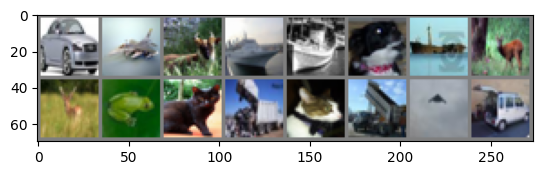

car   plane deer  ship  ship  dog   ship  deer  deer  frog  cat   truck cat   truck plane car  


torch.Size([16, 3, 32, 32])

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

images.shape

In [58]:
images_d = images.to(device)
labels_d = labels.to(device)
model.en_gradCam()
out = model(images_d)
_, predicted = torch.max(out, 1)

grad_Activation_map = model.showGradCAM(criterion, out, labels_d)

torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 4, 4]) torch.Size([16, 256, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 128, 8, 8]) torch.Size([16, 128, 1, 1])
torch.Size([16, 64, 16, 16]) torch.Size([16, 64, 1, 1])
torch.Size([16, 64, 16, 16]) torch.Size([16, 64,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

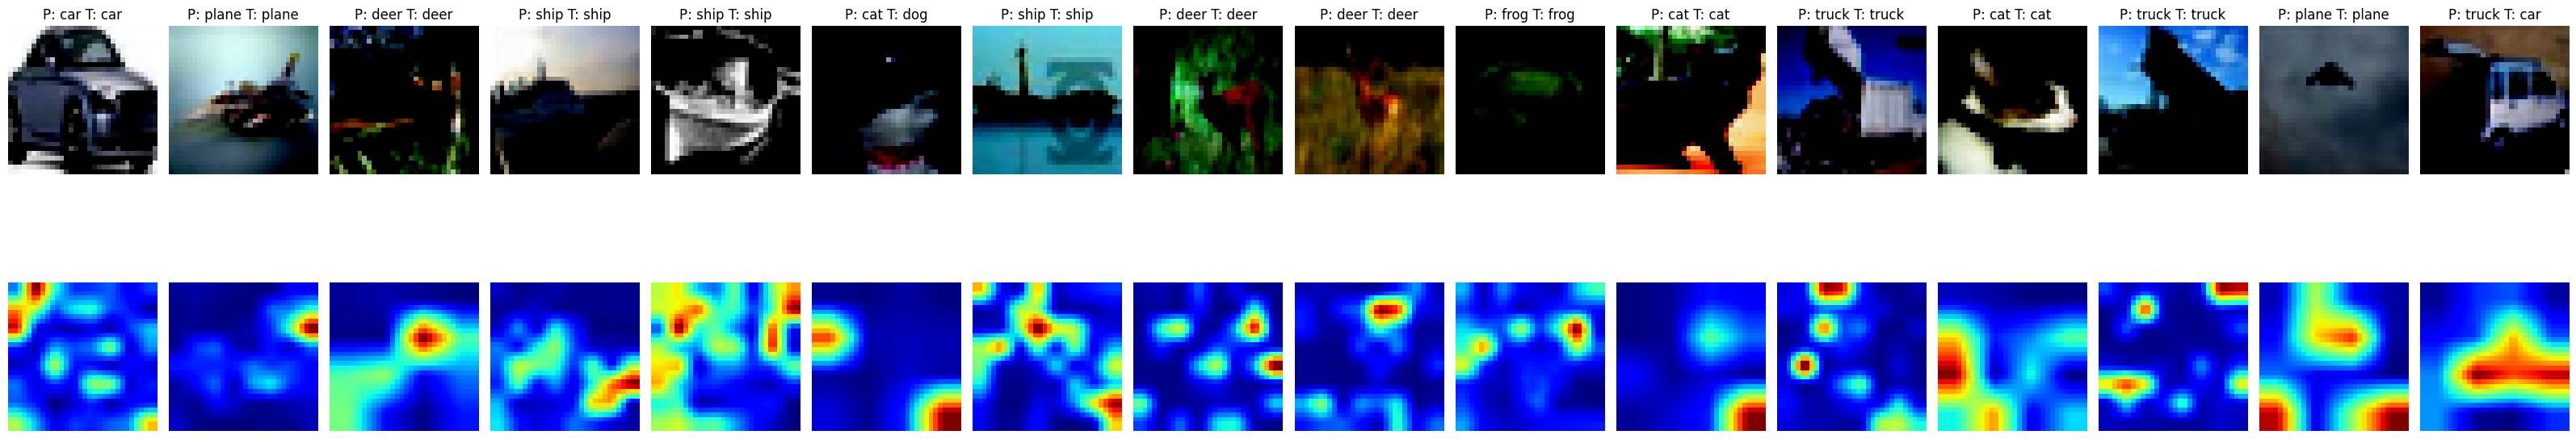

In [59]:
fig, axes = plt.subplots(2, batch_size, figsize=(2 * batch_size, 8))

for i in range(batch_size):
    # Original Image
    ax = axes[0, i]  # First row for the original image
    ax.imshow(np.transpose(images[i].cpu().detach().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f"P: {classes[predicted[i]]} T: {classes[labels[i]]}")

    # Grad-CAM Activation Map
    ax = axes[1, i]  # Second row for the Grad-CAM
    ax.imshow(grad_Activation_map[i].cpu().detach().numpy(), cmap='jet')
    ax.axis('off')

plt.tight_layout()
plt.show()
